In [54]:
# dal lavoro originale di: V. Ram, L. Schaposnik, A modified age-structured SIR model for COVID-19 type
# viruses, https://doi.org/10.1038/s41598-021-94609-3 2021

import pandas as pd
# fati demografici
file_path = 'washington_pop.csv'
pop_df = pd.read_csv(file_path)


#pop_df.head()

#Calcolo popolazione totale ciascuna contea
pop_df['total_pop'] = pop_df[
    ['AGE0_9_TOT', 'AGE10_19_TOT', 'AGE20_29_TOT', 'AGE30_39_TOT', 'AGE40_49_TOT', 
     'AGE50_59_TOT', 'AGE60_69_TOT', 'AGE70_79_TOT', 'AGE80PLUS_TOT']
].sum(axis=1)

#Calcolo proporzioni popolazione per ciascuna fascia d'età
age_distribution = pop_df[
    ['AGE0_9_TOT', 'AGE10_19_TOT', 'AGE20_29_TOT', 'AGE30_39_TOT', 'AGE40_49_TOT', 
     'AGE50_59_TOT', 'AGE60_69_TOT', 'AGE70_79_TOT', 'AGE80PLUS_TOT']
].div(pop_df['total_pop'], axis=0)
age_distribution['CTYNAME'] = pop_df['CTYNAME']


print(age_distribution)

   AGE0_9_TOT  AGE10_19_TOT  AGE20_29_TOT  AGE30_39_TOT  AGE40_49_TOT  \
0    0.178578      0.199856      0.134486      0.118684      0.107253   
1    0.090436      0.097639      0.075497      0.098840      0.116180   
2    0.056712      0.064929      0.061695      0.092869      0.094026   
3    0.103668      0.109645      0.144183      0.182389      0.140055   

   AGE50_59_TOT  AGE60_69_TOT  AGE70_79_TOT  AGE80PLUS_TOT           CTYNAME  
0      0.093084      0.086359      0.055956       0.025744      Adams County  
1      0.129252      0.184340      0.153795       0.054022      Ferry County  
2      0.116658      0.216290      0.214926       0.081895  Jefferson County  
3      0.120845      0.101691      0.065476       0.032047       King County  


In [55]:
# esempio semplice simulazione con una contea
county = age_distribution.iloc[0]

# così prendiamo i dati di una sola contea e possiamo usarli nel seguente modello
county_age_distribution = county.drop('CTYNAME').values



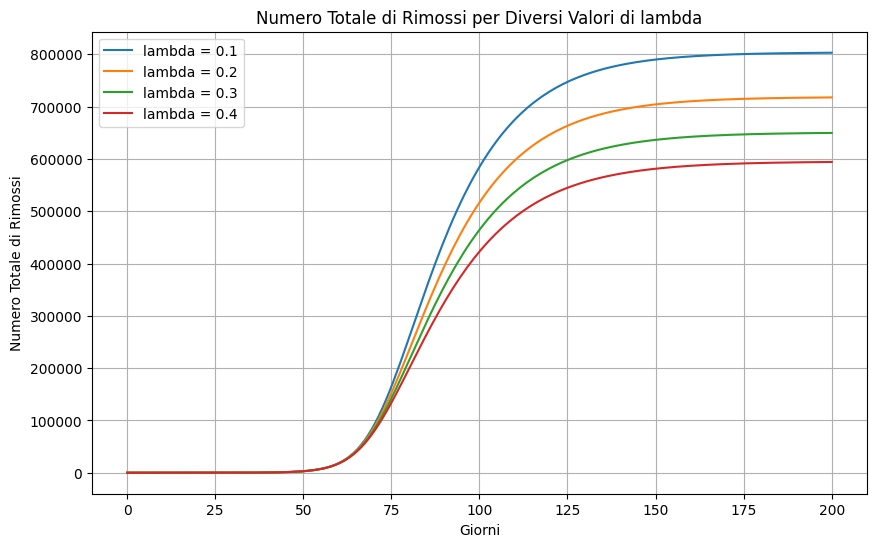

In [51]:
plt.figure(figsize=(10, 6))

# Simulazione per diversi valori di lambda
for lambda_param in lambda_values:
    S0 = age_distribution.copy()
    I0 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])
    R0 = np.zeros(9)
    H0 = np.zeros(9)
    C0 = np.zeros(9)
    M0 = np.zeros(9)
    y0 = np.concatenate([S0, I0, R0, H0, C0, M0])
    
    # Risoluzione del sistema di ODE
    ret = odeint(deriv, y0, t, args=(beta, gamma, M, N, C_max, h, c, m, lambda_param, epsilon, max_mitigation))
    S, I, R, H, C, M_death = np.split(ret.T, 6)
    
    #risultati per i rimossi totali
    total_removed = np.sum(R, axis=0)
    
    plt.plot(t, total_removed, label=f'lambda = {lambda_param}')

plt.title('Totale Rimossi per Diversi Valori di lambda')
plt.xlabel('Giorni')
plt.ylabel('Numero Totale di Rimossi')
plt.legend()
plt.grid(True)
plt.show()


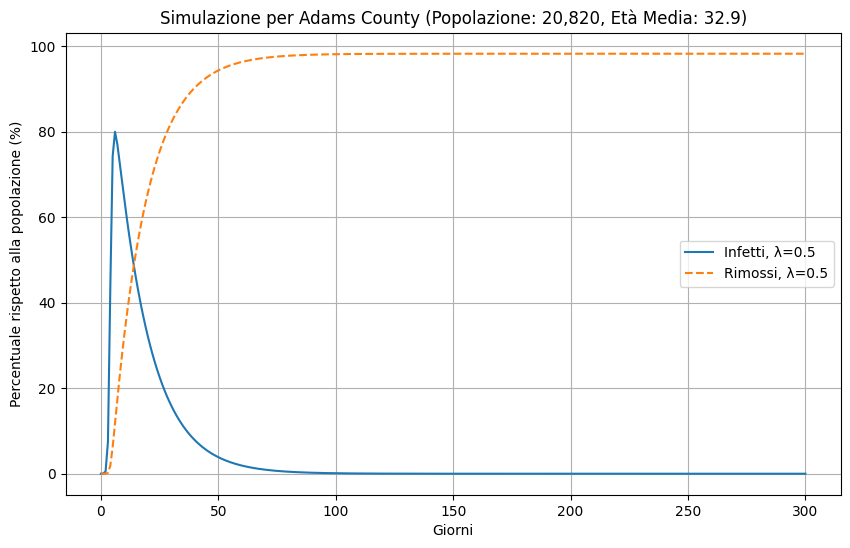

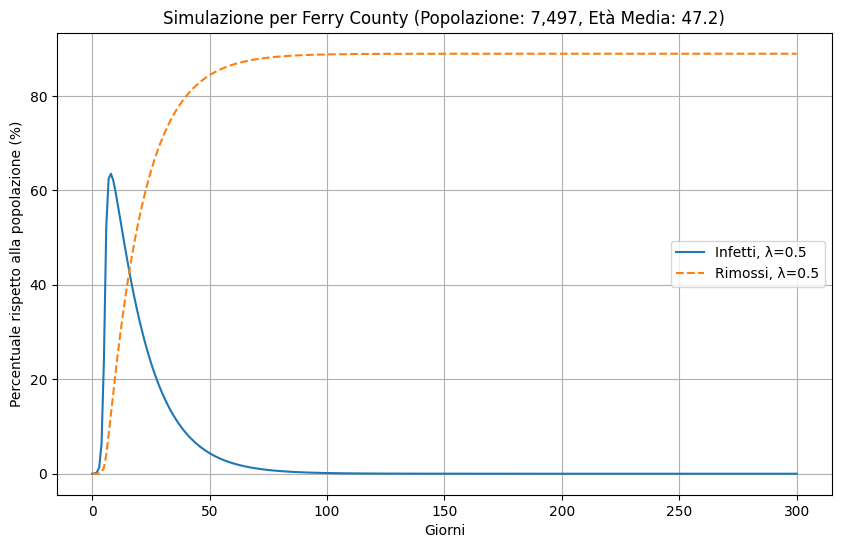

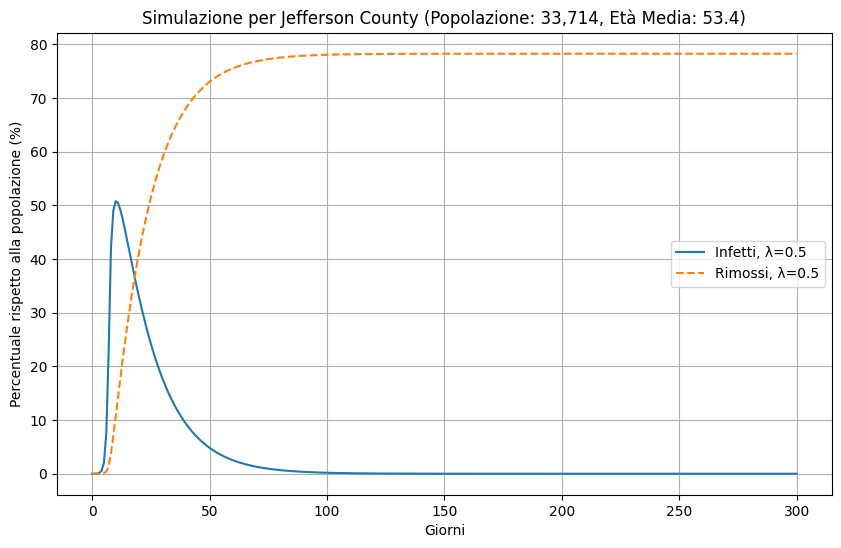

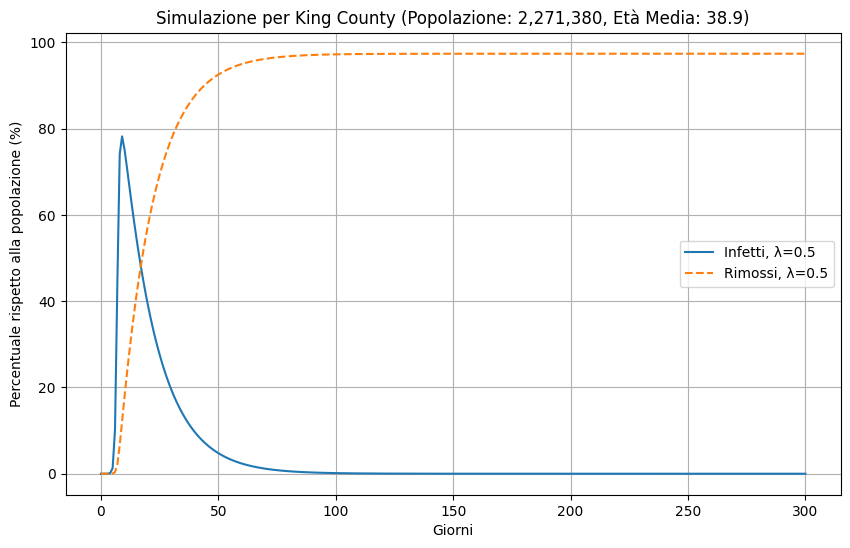

In [88]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


file_path = 'washington_pop.csv'
pop_df = pd.read_csv(file_path)

pop_df['total_pop'] = pop_df[
    ['AGE0_9_TOT', 'AGE10_19_TOT', 'AGE20_29_TOT', 'AGE30_39_TOT', 'AGE40_49_TOT', 
     'AGE50_59_TOT', 'AGE60_69_TOT', 'AGE70_79_TOT', 'AGE80PLUS_TOT']
].sum(axis=1)

age_distribution = pop_df[
    ['AGE0_9_TOT', 'AGE10_19_TOT', 'AGE20_29_TOT', 'AGE30_39_TOT', 'AGE40_49_TOT', 
     'AGE50_59_TOT', 'AGE60_69_TOT', 'AGE70_79_TOT', 'AGE80PLUS_TOT']
].div(pop_df['total_pop'], axis=0)

age_distribution['CTYNAME'] = pop_df['CTYNAME']

# Calcolo età media per ciascuna contea
age_midpoints = np.array([4.5, 14.5, 24.5, 34.5, 44.5, 54.5, 64.5, 74.5, 85])  # Valori medi per ciascuna fascia d'età
pop_df['mean_age'] = (pop_df[['AGE0_9_TOT', 'AGE10_19_TOT', 'AGE20_29_TOT', 'AGE30_39_TOT', 'AGE40_49_TOT', 
                              'AGE50_59_TOT', 'AGE60_69_TOT', 'AGE70_79_TOT', 'AGE80PLUS_TOT']].values * age_midpoints).sum(axis=1) / pop_df['total_pop']

beta = 0.3  # tasso di trasmissione
gamma = 1/14  # tasso di recupero (14 giorni di infezione)

# Matrice di contatto reale corretta presa dallo studio
M = np.array([
    [19.2, 4.8, 3.0, 7.1, 3.7, 3.1, 2.3, 1.4, 1.4],
    [4.8, 42.4, 6.4, 5.4, 7.5, 5.0, 1.8, 1.7, 1.7],
    [3.0, 6.4, 20.7, 9.2, 7.1, 6.3, 2.0, 0.9, 0.9],
    [7.1, 5.4, 9.2, 16.9, 10.1, 6.8, 3.4, 1.5, 1.5],
    [3.7, 7.5, 7.1, 10.1, 13.1, 7.4, 2.6, 2.1, 2.1],
    [3.1, 5.0, 6.3, 6.8, 7.4, 10.4, 3.5, 1.8, 1.8],
    [2.3, 1.8, 2.0, 3.4, 2.6, 3.5, 7.5, 3.2, 3.2],
    [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2],
    [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2]
])

# Distribuzione dei vaccini
def vaccination_rate(t, omega, age_distribution):
    # esempio: distribuzione uniforme
    T = N / 720  # numero di vaccini giornalieri
    return omega * T / age_distribution

# Funzione di mitigazione con limitazione
def mitigation_factor(C, C_max, lambda_param, epsilon):
    C_total = np.sum(C)  # Numero totale di persone in ICU
    mitigation = 1 / (lambda_param * (C_total / C_max + epsilon))
    return min(mitigation, 1)  # Limitare il fattore di mitigazione a un massimo di 1

def deriv(y, t, beta, gamma, M, N, C_max, h, c, m, lambda_param, epsilon):
    S, I, R, H, C, M_death = np.split(y, 6)
    mitigation = mitigation_factor(C, C_max, lambda_param, epsilon)
    M_t = M * mitigation  # Matrice di contatto mitigata
    
    dSdt = -beta * S / N * np.dot(M_t, I)
    dIdt = beta * S / N * np.dot(M_t, I) - gamma * I
    dRdt = gamma * I
    dHdt = gamma * h * I
    dCdt = gamma * h * c * I
    dMdt = gamma * m * I
    
    return np.concatenate([dSdt, dIdt, dRdt, dHdt, dCdt, dMdt])


gg = 300
# Simulazione per una singola contea
def simulate_county(county_age_distribution, total_population, lambda_value):
    S0 = (county_age_distribution.astype(float) * total_population).copy()  # Converti la distribuzione in numeri assoluti
    I0 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])  # Aumentiamo il numero iniziale di infetti
    R0 = np.zeros(9)
    H0 = np.zeros(9)
    C0 = np.zeros(9)
    M0 = np.zeros(9)
    y0 = np.concatenate([S0, I0, R0, H0, C0, M0])
    
    t = np.linspace(0, gg, gg)
    ret = odeint(deriv, y0, t, args=(beta, gamma, M, N, C_max, h, c, m, lambda_value, epsilon))
    S, I, R, H, C, M_death = np.split(ret.T, 6)
    
    return S, I, R, H, C, M_death, t

# Parametri per la simulazione
lambda_values = [0.5]

for i, county in age_distribution.iterrows():
    county_age_distribution = county.drop('CTYNAME').values
    total_population = pop_df.loc[i, 'total_pop']  # Ottieni la popolazione totale della contea
    mean_age = pop_df.loc[i, 'mean_age']  # Ottieni l'età media della contea
    N = total_population
    C_max = 34.7 / 100000 * total_population  # Capacità massima delle ICU in base alla popolazione totale
    plt.figure(figsize=(10, 6))
    
    for lambda_value in lambda_values:
        S, I, R, H, C, M_death, t = simulate_county(county_age_distribution, total_population, lambda_value)
        
        # Calcola la percentuale di infetti rispetto alla popolazione totale
        infetti_percentuale = (np.sum(I, axis=0) / total_population) * 100
        rimossi_percentuale = (np.sum(R, axis=0) / total_population) * 100
        plt.plot(t, infetti_percentuale, label=f'Infetti, λ={lambda_value}')
        plt.plot(t, rimossi_percentuale, '--', label=f'Rimossi, λ={lambda_value}')
    
    plt.title(f'Simulazione per {county["CTYNAME"]} (Popolazione: {int(total_population):,}, Età Media: {mean_age:.1f})')
    plt.xlabel('Giorni')
    plt.ylabel('Percentuale rispetto alla popolazione (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

## altri grafici

In [ ]:
#risultati per infetti, ospedalizzati, ICU e decessi
plt.figure(figsize=(15, 12))

# Grafico degli infetti
plt.subplot(4, 1, 1)
for i in range(9):
    plt.plot(t, I[i], label=f'Fascia {i*10}-{i*10+9}')
plt.title('Numero di Infetti per Fascia d\'Età')
plt.xlabel('Giorni')
plt.ylabel('Numero di Infetti')
plt.legend()

# Grafico degli ospedalizzati
plt.subplot(4, 1, 2)
for i in range(9):
    plt.plot(t, H[i], label=f'Fascia {i*10}-{i*10+9}')
plt.title('Numero di Ospedalizzati per Fascia d\'Età')
plt.xlabel('Giorni')
plt.ylabel('Numero di Ospedalizzati')
plt.legend()

#Grafico ICU (terapia intensiva)
plt.subplot(4, 1, 3)
for i in range(9):
    plt.plot(t, C[i], label=f'Fascia {i*10}-{i*10+9}')
plt.title('Numero in Terapia Intensiva (ICU) per Fascia d\'Età')
plt.xlabel('Giorni')
plt.ylabel('Numero in Terapia Intensiva')
plt.legend()

# Grafico dei decessi
plt.subplot(4, 1, 4)
for i in range(9):
    plt.plot(t, M_death[i], label=f'Fascia {i*10}-{i*10+9}')
plt.title('Numero di Decessi per Fascia d\'Età')
plt.xlabel('Giorni')
plt.ylabel('Numero di Decessi')
plt.legend()

plt.tight_layout()
plt.show()


## vaccini

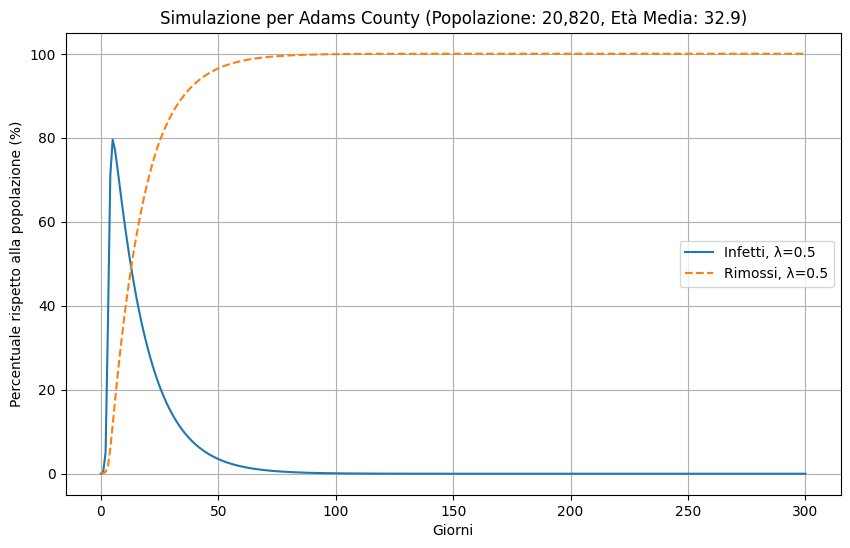

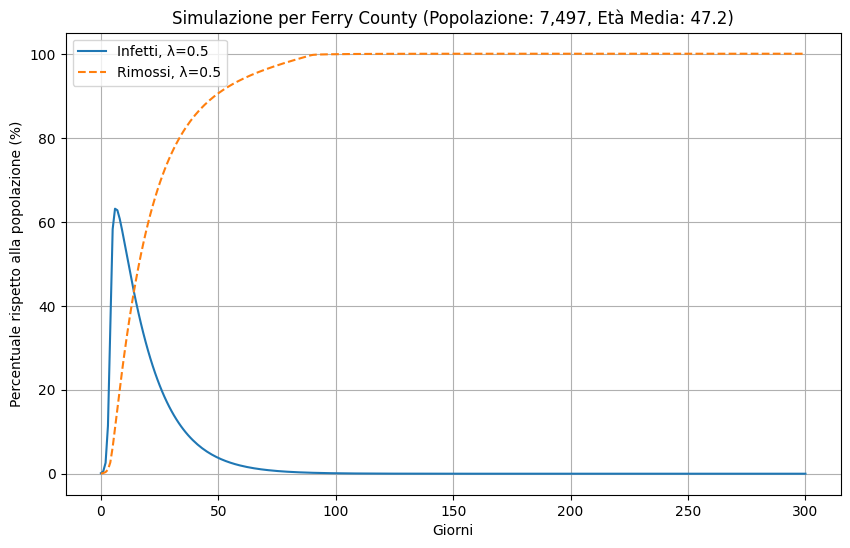

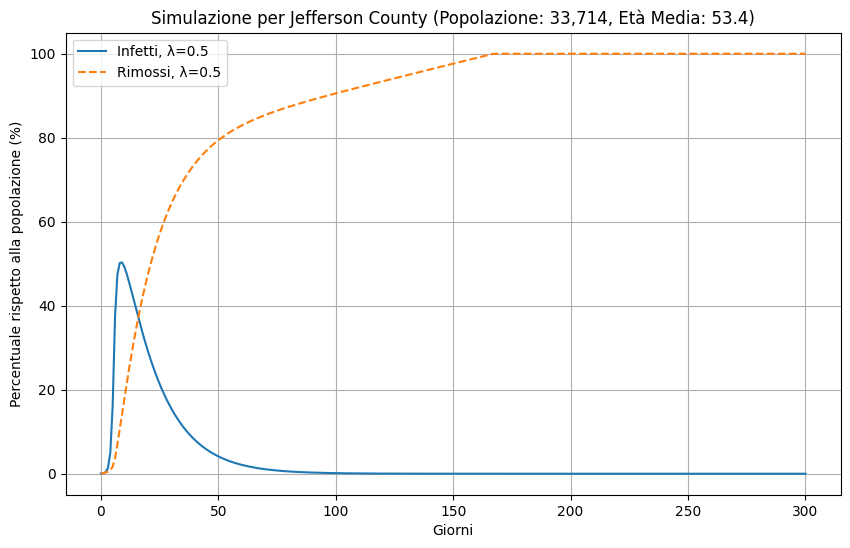

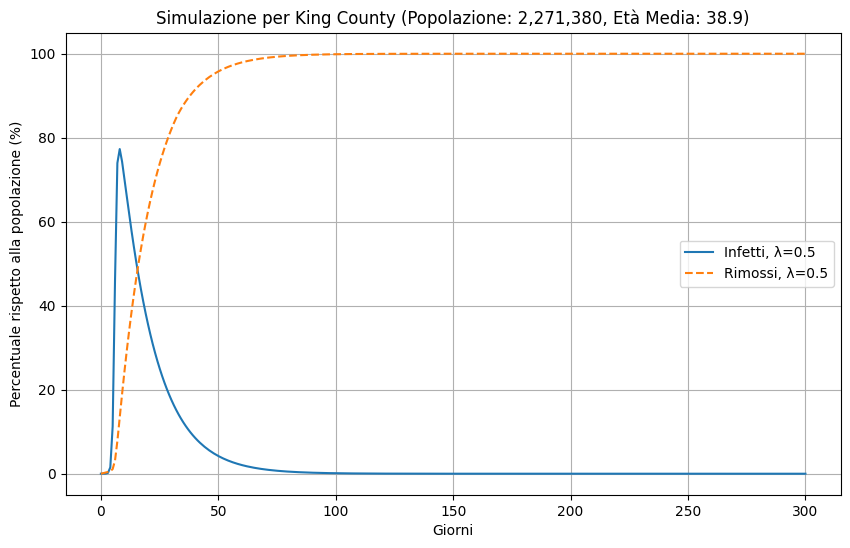

In [103]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

file_path = 'washington_pop.csv'
pop_df = pd.read_csv(file_path)

pop_df['total_pop'] = pop_df[
    ['AGE0_9_TOT', 'AGE10_19_TOT', 'AGE20_29_TOT', 'AGE30_39_TOT', 'AGE40_49_TOT', 
     'AGE50_59_TOT', 'AGE60_69_TOT', 'AGE70_79_TOT', 'AGE80PLUS_TOT']
].sum(axis=1)

age_distribution = pop_df[
    ['AGE0_9_TOT', 'AGE10_19_TOT', 'AGE20_29_TOT', 'AGE30_39_TOT', 'AGE40_49_TOT', 
     'AGE50_59_TOT', 'AGE60_69_TOT', 'AGE70_79_TOT', 'AGE80PLUS_TOT']
].div(pop_df['total_pop'], axis=0)

age_distribution['CTYNAME'] = pop_df['CTYNAME']

age_midpoints = np.array([4.5, 14.5, 24.5, 34.5, 44.5, 54.5, 64.5, 74.5, 85])  # Valori medi per ciascuna fascia d'età
pop_df['mean_age'] = (pop_df[['AGE0_9_TOT', 'AGE10_19_TOT', 'AGE20_29_TOT', 'AGE30_39_TOT', 'AGE40_49_TOT', 
                              'AGE50_59_TOT', 'AGE60_69_TOT', 'AGE70_79_TOT', 'AGE80PLUS_TOT']].values * age_midpoints).sum(axis=1) / pop_df['total_pop']

beta = 0.3  # tasso di trasmissione
gamma = 1/14  # tasso di recupero (14 giorni di infezione)

M = np.array([
    [19.2, 4.8, 3.0, 7.1, 3.7, 3.1, 2.3, 1.4, 1.4],
    [4.8, 42.4, 6.4, 5.4, 7.5, 5.0, 1.8, 1.7, 1.7],
    [3.0, 6.4, 20.7, 9.2, 7.1, 6.3, 2.0, 0.9, 0.9],
    [7.1, 5.4, 9.2, 16.9, 10.1, 6.8, 3.4, 1.5, 1.5],
    [3.7, 7.5, 7.1, 10.1, 13.1, 7.4, 2.6, 2.1, 2.1],
    [3.1, 5.0, 6.3, 6.8, 7.4, 10.4, 3.5, 1.8, 1.8],
    [2.3, 1.8, 2.0, 3.4, 2.6, 3.5, 7.5, 3.2, 3.2],
    [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2],
    [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2]
])

# Definizione della funzione di vaccinazione secondo l'articolo
def vaccination_rate(S, total_population, priority):
    T = total_population / 720  # Numero di vaccini somministrati al giorno
    weighted_S = priority * S
    sum_weighted_S = np.sum(weighted_S)
    
    if sum_weighted_S > 0:
        mu = T * (weighted_S / sum_weighted_S)  #vettore di vaccifnazione per ciascuna fascia d'età
    else:
        mu = np.zeros_like(S)  #se non ci sono più suscettibili , la vaccinazione si ferma
    
    
    mu = np.minimum(mu, S)
    
    return mu

# Funzione di mitigazione con limitazione
def mitigation_factor(C, C_max, lambda_param, epsilon):
    C_total = np.sum(C)  # Numero totale di persone in ICU
    mitigation = 1 / (lambda_param * (C_total / C_max + epsilon))
    return min(mitigation, 1)  # Limitare il fattore di mitigazione a un massimo di 1


def deriv(y, t, beta, gamma, M, N, C_max, h, c, m, lambda_param, epsilon, priority):
    S, I, R, H, C, M_death = np.split(y, 6)
    mitigation = mitigation_factor(C, C_max, lambda_param, epsilon)
    M_t = M * mitigation  # Matrice di contatto mitigata
    
    vaccination_vector = vaccination_rate(S, N, priority)
    
    dSdt = -beta * S / N * np.dot(M_t, I) - vaccination_vector
    dIdt = beta * S / N * np.dot(M_t, I) - gamma * I
    dRdt = gamma * I + vaccination_vector
    dHdt = gamma * h * I
    dCdt = gamma * h * c * I
    dMdt = gamma * m * I
    
    return np.concatenate([dSdt, dIdt, dRdt, dHdt, dCdt, dMdt])


gg = 300
def simulate_county(county_age_distribution, total_population, lambda_value, priority):
    S0 = (county_age_distribution.astype(float) * total_population).copy()  # Converti la distribuzione in numeri assoluti
    I0 = np.array([10, 0, 0, 0, 0, 0, 0, 0, 0])  # Aumentiamo il numero iniziale di infetti
    R0 = np.zeros(9)
    H0 = np.zeros(9)
    C0 = np.zeros(9)
    M0 = np.zeros(9)
    y0 = np.concatenate([S0, I0, R0, H0, C0, M0])
    
    t = np.linspace(0, gg, gg)  
    ret = odeint(deriv, y0, t, args=(beta, gamma, M, total_population, C_max, h, c, m, lambda_value, epsilon, priority))
    S, I, R, H, C, M_death = np.split(ret.T, 6)
    
    R = np.minimum(R, total_population)
    
    return S, I, R, H, C, M_death

lambda_values = [0.5]

#priority = np.array([1, 1, 1, 2, 2, 3, 4, 5, 5])
priority = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])

for i, county in age_distribution.iterrows():
    county_age_distribution = county.drop('CTYNAME').values
    total_population = pop_df.loc[i, 'total_pop']  
    mean_age = pop_df.loc[i, 'mean_age']  
    N = total_population
    C_max = 34.7 / 100000 * total_population  
    plt.figure(figsize=(10, 6))
    
    for lambda_value in lambda_values:
        S, I, R, H, C, M_death = simulate_county(county_age_distribution, total_population, lambda_value, priority)
        
        
        infetti_percentuale = (np.sum(I, axis=0) / total_population) * 100
        rimossi_percentuale = (np.sum(R, axis=0) / total_population) * 100
        
        plt.plot(np.linspace(0, gg, gg), infetti_percentuale, label=f'Infetti, λ={lambda_value}')
        plt.plot(np.linspace(0, gg, gg), rimossi_percentuale, '--', label=f'Rimossi, λ={lambda_value}')
    
    plt.title(f'Simulazione per {county["CTYNAME"]} (Popolazione: {int(total_population):,}, Età Media: {mean_age:.1f})')
    plt.xlabel('Giorni')
    plt.ylabel('Percentuale rispetto alla popolazione (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

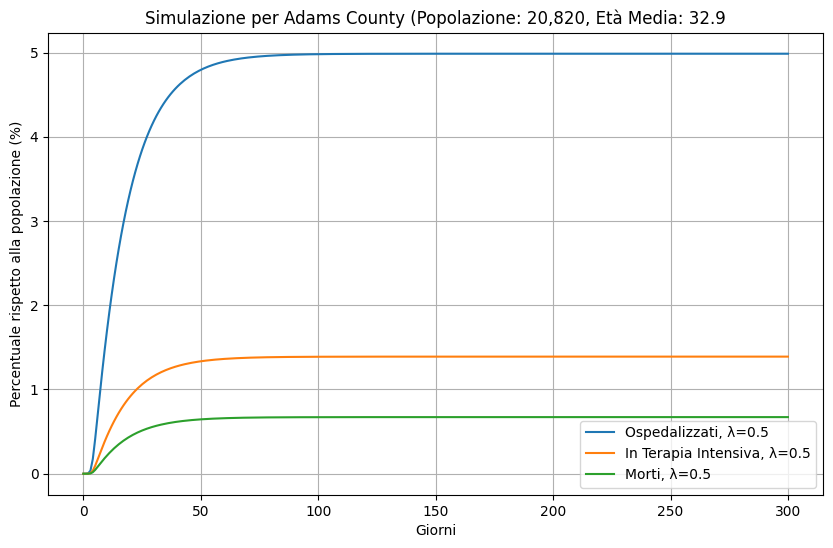

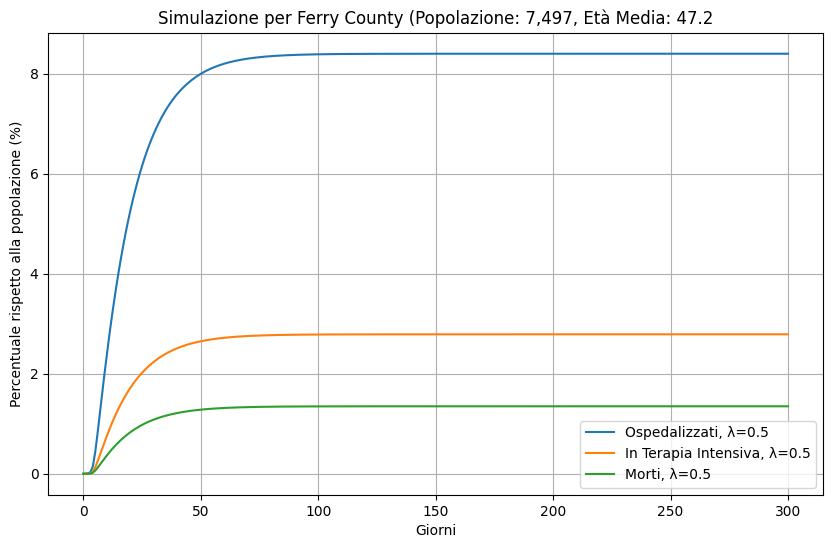

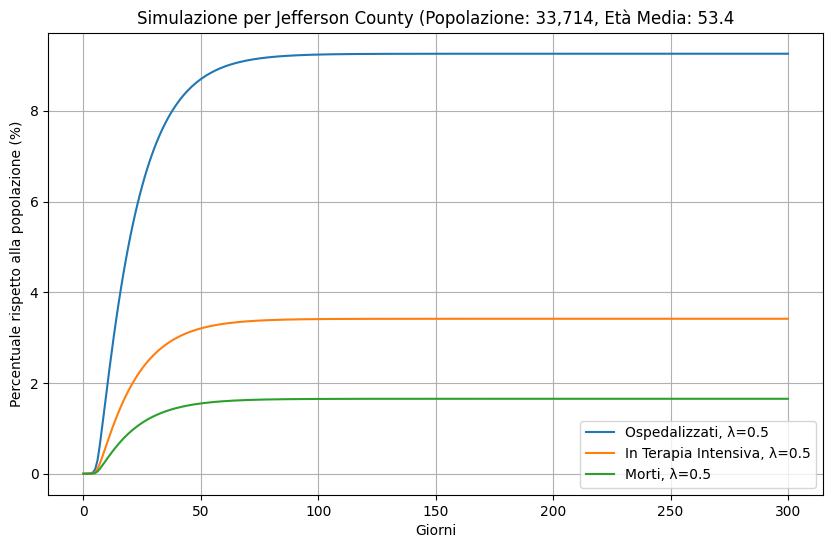

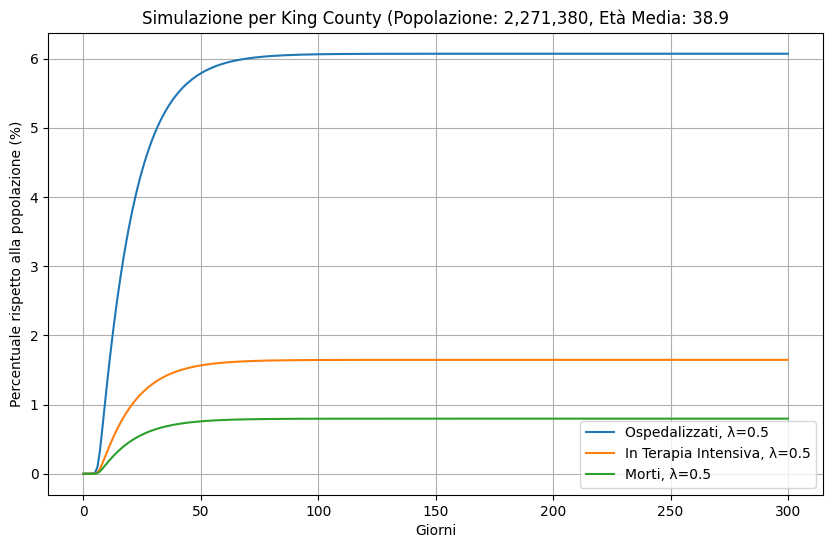

In [118]:
#priority = np.array([1, 1, 1, 2, 2, 3, 4, 20, 20])
priority = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])

# Definizione della funzione di vaccinazione secondo l'articolo
def vaccination_rate(S, total_population, priority):
    T = total_population / 720  # Numero di vaccini somministrati al giorno
    weighted_S = priority * S
    sum_weighted_S = np.sum(weighted_S)
    
    if sum_weighted_S > 0:
        mu = T * (weighted_S / sum_weighted_S)  
    else:
        mu = np.zeros_like(S)  
    
    
    mu = np.minimum(mu, S)
    
    return mu

# Funzione di mitigazione con limitazione
def mitigation_factor(C, C_max, lambda_param, epsilon):
    C_total = np.sum(C)  # Numero totale di persone in ICU
    mitigation = 1 / (lambda_param * (C_total / C_max + epsilon))
    return min(mitigation, 1)  # Limitare il fattore di mitigazione a un massimo di 1



def deriv(y, t, beta, gamma, M, N, C_max, h, c, m, lambda_param, epsilon, priority):
    S, I, R, H, C, M_death = np.split(y, 6)
    mitigation = mitigation_factor(C, C_max, lambda_param, epsilon)
    M_t = M * mitigation  # Matrice di contatto mitigata
    
    vaccination_vector = vaccination_rate(S, N, priority)
    
    dSdt = -beta * S / N * np.dot(M_t, I) - vaccination_vector
    dIdt = beta * S / N * np.dot(M_t, I) - gamma * I
    dRdt = gamma * I + vaccination_vector
    dHdt = gamma * h * I
    dCdt = gamma * h * c * I
    dMdt = gamma * m * I
    
    return np.concatenate([dSdt, dIdt, dRdt, dHdt, dCdt, dMdt])


gg = 300
# Simulazione per una singola contea
def simulate_county(county_age_distribution, total_population, lambda_value, priority):
    S0 = (county_age_distribution.astype(float) * total_population).copy()  # Converti la distribuzione in numeri assoluti
    I0 = np.array([10, 0, 0, 0, 0, 0, 0, 0, 0])  # Aumentiamo il numero iniziale di infetti
    R0 = np.zeros(9)
    H0 = np.zeros(9)
    C0 = np.zeros(9)
    M0 = np.zeros(9)
    y0 = np.concatenate([S0, I0, R0, H0, C0, M0])
    
    t = np.linspace(0, gg, gg)  
    ret = odeint(deriv, y0, t, args=(beta, gamma, M, total_population, C_max, h, c, m, lambda_value, epsilon, priority))
    S, I, R, H, C, M_death = np.split(ret.T, 6)
    
    
    R = np.minimum(R, total_population)
    
    return S, I, R, H, C, M_death 


lambda_values = [0.5]


for i, county in age_distribution.iterrows():
    county_age_distribution = county.drop('CTYNAME').values
    total_population = pop_df.loc[i, 'total_pop']  
    mean_age = pop_df.loc[i, 'mean_age']  
    N = total_population
    C_max = 34.7 / 100000 * total_population  
    plt.figure(figsize=(10, 6))
    
    
    for lambda_value in lambda_values:
        S, I, R, H, C, M_death = simulate_county(county_age_distribution, total_population, lambda_value, priority)
        
        # Calcola la percentuale di infetti, rimossi, ospedalizzati, in terapia intensiva e morti rispetto alla popolazione totale
        #infetti_percentuale = (np.sum(I, axis=0) / total_population) * 100
        #rimossi_percentuale = (np.sum(R, axis=0) / total_population) * 100
        ospedalizzati_percentuale = (np.sum(H, axis=0) / total_population) * 100
        ICU_percentuale = (np.sum(C, axis=0) / total_population) * 100
        morti_percentuale = (np.sum(M_death, axis=0) / total_population) * 100
        
        #Grafici per le metriche di gravità principali
        #plt.plot(np.linspace(0, gg, gg), infetti_percentuale, label=f'Infetti, λ={lambda_value}')
        #plt.plot(np.linspace(0, gg, gg), rimossi_percentuale, '--', label=f'Rimossi, λ={lambda_value}')
        plt.plot(np.linspace(0, gg, gg), ospedalizzati_percentuale, label=f'Ospedalizzati, λ={lambda_value}')
        plt.plot(np.linspace(0, gg, gg), ICU_percentuale, label=f'In Terapia Intensiva, λ={lambda_value}')
        plt.plot(np.linspace(0, gg, gg), morti_percentuale, label=f'Morti, λ={lambda_value}')
    
    plt.title(f'Simulazione per {county["CTYNAME"]} (Popolazione: {int(total_population):,}, Età Media: {mean_age:.1f}')
    plt.xlabel('Giorni')
    plt.ylabel('Percentuale rispetto alla popolazione (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


# report progetto modelli biomedicina: nuova funzione mitigazione

In [207]:
import pandas as pd

#Lista per raccogliere i risultati
results = []

#Esegui simulazione per ogni valore di beta_decay e raccogli le metriche
for i, county in age_distribution.iterrows():
    county_age_distribution = county.drop('CTYNAME').values
    total_population = pop_df.loc[i, 'total_pop']
    mean_age = pop_df.loc[i, 'mean_age']
    N = total_population
    C_max = 34.7 / 10000 * total_population
    
    for beta_decay in beta_decay_values:  
        print(f"Simulazione per la contea {county['CTYNAME']} con beta_decay = {beta_decay}")
        
        for gamma in gamma_values:
            beta = 2 * R0 * gamma / lambda_dominant  
            
            for lambda_value in lambda_values:
                S, I, R, H, C, M_death = simulate_county(county_age_distribution, total_population, lambda_value, priority, beta_decay)
                
                
                infetti_percentuale = (np.sum(I, axis=0) / total_population) * 100
                rimossi_percentuale = (np.sum(R, axis=0) / total_population) * 100
                ospedalizzati_percentuale = (np.sum(H, axis=0) / total_population) * 100
                ICU_percentuale = (np.sum(C, axis=0) / total_population) * 100
                morti_percentuale = (np.sum(M_death, axis=0) / total_population) * 100
                
                # Calcola il picco degli infetti e il giorno del picco
                peak_infected = np.max(np.sum(I, axis=0)) / total_population * 100
                day_peak_infected = np.argmax(np.sum(I, axis=0)) / step
                total_removed = np.sum(R[:, -1]) / total_population * 100
                total_hospitalized = np.sum(H[:, -1]) / total_population * 100
                total_icu = np.sum(C[:, -1]) / total_population * 100
                total_deaths = np.sum(M_death[:, -1]) / total_population * 100
                
                # Aggiungi i risultati alla lista
                results.append({
                    'County': county['CTYNAME'],
                    'Beta Decay': beta_decay,
                    'Gamma': round(gamma, 4),
                    'Beta': round(beta, 4),
                    'Peak Infected (%)': peak_infected,
                    'Day of Peak Infected': day_peak_infected,
                    'Total Removed (%)': total_removed,
                    'Total Hospitalized (%)': total_hospitalized,
                    'Total ICU (%)': total_icu,
                    'Total Deaths (%)': total_deaths
                })


df_results = pd.DataFrame(results)


df_results.to_csv('simulation_metrics_beta_decay.csv', index=False)


print(df_results)


Simulazione per la contea Adams County con beta_decay = 1
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1

Simulazione con beta_decay = 1
Simulazione con beta_decay = 5
Simulazione con beta_decay = 10
Simulazione con beta_decay = 20
Simulazione per la contea Adams County con beta_decay = 1
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


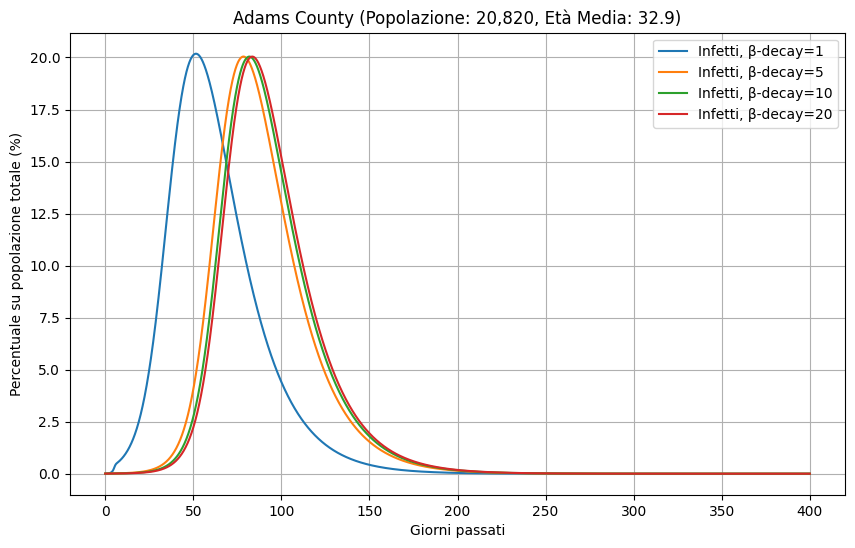

Simulazione per la contea Ferry County con beta_decay = 1
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1

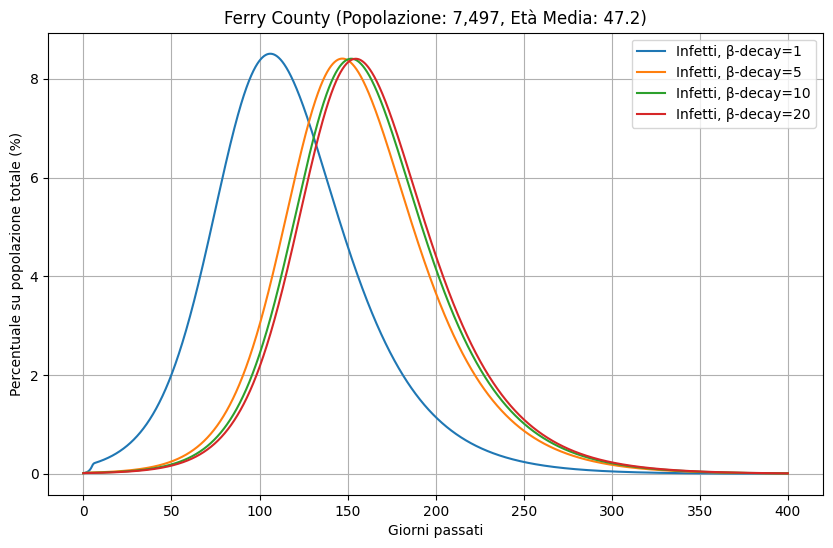

Simulazione per la contea Jefferson County con beta_decay = 1
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 

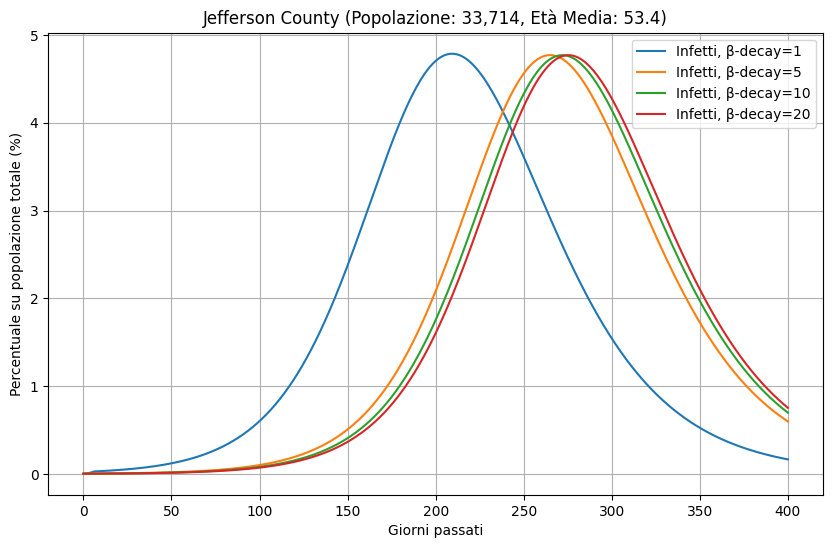

Simulazione per la contea King County con beta_decay = 1
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mitigation factor: [1. 1. 1. 1.

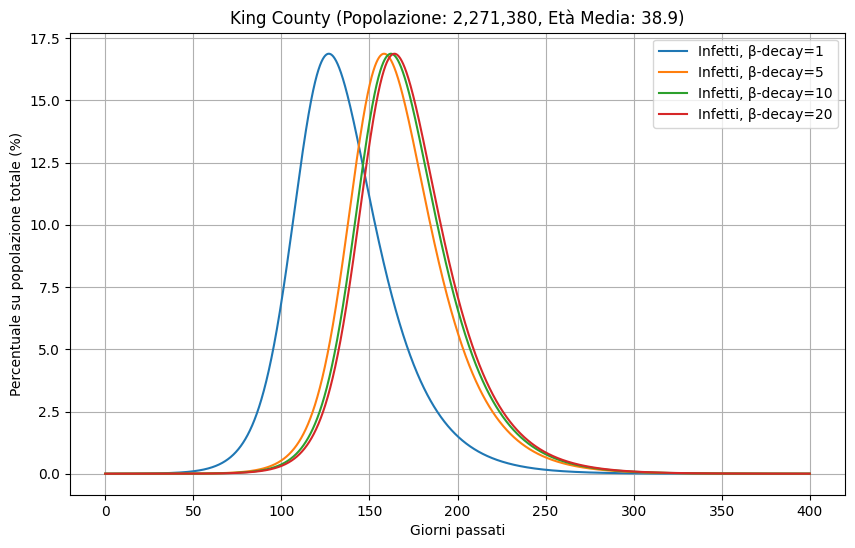

             County   Gamma  Beta  Beta_decay  Peak Infected (%)  \
0      Adams County  0.0714  0.11          20          20.043253   
1      Ferry County  0.0714  0.11          20           8.407435   
2  Jefferson County  0.0714  0.11          20           4.769233   
3       King County  0.0714  0.11          20          16.874279   

   Day of Peak Infected  Total Removed (%)  Total Hospitalized (%)  \
0                  83.4          78.437391                3.107477   
1                 154.6          58.676627                4.926498   
2                 275.3          46.657776                5.281344   
3                 164.1          75.878977                3.967995   

   Total ICU (%)  Total Deaths (%)  
0       0.719309          0.347801  
1       1.525264          0.737803  
2       1.896691          0.917348  
3       0.893935          0.432487  


In [208]:

beta_decay_values = [1, 5, 10, 20]  # Esegui simulazioni su diversi valori
min_mitigation = 0.2
def mitigation_factor_combined(C, C_max, lambda_param, epsilon, t, beta_decay, min_mitigation):
    icu_component = 1 / (lambda_param * (C / C_max + epsilon))
    time_decay_component = np.exp(-beta_decay * t)
    mitigation1 = icu_component * time_decay_component
    mitigation2 = np.maximum(mitigation1, min_mitigation)
    mitigation = np.minimum(mitigation2, 1)
    #mitigation=1
    print(f'Mitigation factor: {mitigation}')  # Debugging
    return mitigation

#priority = np.array([1, 1, 1, 2, 2, 3, 4, 20, 20])
priority = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])



M = np.array([
    [19.2, 4.8, 3.0, 7.1, 3.7, 3.1, 2.3, 1.4, 1.4],
    [4.8, 42.4, 6.4, 5.4, 7.5, 5.0, 1.8, 1.7, 1.7],
    [3.0, 6.4, 20.7, 9.2, 7.1, 6.3, 2.0, 0.9, 0.9],
    [7.1, 5.4, 9.2, 16.9, 10.1, 6.8, 3.4, 1.5, 1.5],
    [3.7, 7.5, 7.1, 10.1, 13.1, 7.4, 2.6, 2.1, 2.1],
    [3.1, 5.0, 6.3, 6.8, 7.4, 10.4, 3.5, 1.8, 1.8],
    [2.3, 1.8, 2.0, 3.4, 2.6, 3.5, 7.5, 3.2, 3.2],
    [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2],
    [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2]
])
# Calcola la proporzione della popolazione in ogni fascia d'età
p = county_age_distribution / np.sum(county_age_distribution)

# Costruisci la matrice normalizzata M_normalized
M_normalized = np.dot(M, np.diag(p))
M_normalized = M_normalized.astype(float)

eigenvalues, eigenvectors = np.linalg.eig(M_normalized)
dominant_index = np.argmax(eigenvalues)
lambda_dominant = eigenvalues[dominant_index]
v_dominant = eigenvectors[:, dominant_index]


#gamma = 1 / 14  # Periodo infettivo di 14 giorni
R0 = 5.7  # Numero riproduttivo di base per il covid


gamma_values = np.array([1/14])


# Definizione della funzione di vaccinazione secondo l'articolo
def vaccination_rate(S, total_population, priority):
    T = total_population / 720  # Numero di vaccini somministrati al giorno
    weighted_S = priority * S
    sum_weighted_S = np.sum(weighted_S)
    
    if sum_weighted_S > 0:
        mu = T * (weighted_S / sum_weighted_S)  # Vettore di vaccinazione per ciascuna fascia d'età
    else:
        mu = np.zeros_like(S)  
    
    
    mu = np.minimum(mu, S)
    mu = 0
    return mu




def deriv(y, t, beta, gamma, M, N, C_max, h, c, m, lambda_param, epsilon, priority, beta_decay):
    S, I, R, H, C, M_death = np.split(y, 6)
    mitigation = mitigation_factor_combined(C, C_max, lambda_param, epsilon, t, beta_decay, min_mitigation)
    M_t = M * mitigation  # Matrice di contatto mitigata
    
    vaccination_vector = vaccination_rate(S, N, priority)
    
    dSdt = -beta * S / N * np.dot(M_t, I) - vaccination_vector
    dIdt = beta * S / N * np.dot(M_t, I) - gamma * I
    dRdt = gamma * I + vaccination_vector
    dHdt = gamma * h * I
    dCdt = gamma * h * c * I
    dMdt = gamma * m * I
    
    return np.concatenate([dSdt, dIdt, dRdt, dHdt, dCdt, dMdt])


gg = 400
step = 10

def simulate_county(county_age_distribution, total_population, lambda_value, priority, beta_decay):
    S0 = (county_age_distribution.astype(float) * total_population).copy()
    I0 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0]) 
    R0 = np.zeros(9)
    H0 = np.zeros(9)
    C0 = np.zeros(9)
    M0 = np.zeros(9)
    y0 = np.concatenate([S0, I0, R0, H0, C0, M0])
    
    t = np.linspace(0, gg, gg*step)
    ret = odeint(deriv, y0, t, args=(beta, gamma, M, total_population, C_max, h, c, m, lambda_value, epsilon, priority, beta_decay))
    S, I, R, H, C, M_death = np.split(ret.T, 6)
    
    R = np.minimum(R, total_population)
    
    return S, I, R, H, C, M_death 


#lambda_values = [0.5]


#gamma_values = [1/3, 1/7, 1/14]  # 3 giorni, 7 giorni, 14 giorni
#R0 = 5.7  # Numero riproduttivo di base


lambda_values = [lambda_dominant]

##Inizializza una lista per salvare i risultati
results = []

# Esegui la simulazione per ogni valore di beta_decay
for beta_decay in beta_decay_values:
    print(f"Simulazione con beta_decay = {beta_decay}")
    
    # Esegui la simulazione per ogni valore di beta_decay e plottali su grafici separati per ogni contea
for i, county in age_distribution.iterrows():
    county_age_distribution = county.drop('CTYNAME').values
    total_population = pop_df.loc[i, 'total_pop']
    mean_age = pop_df.loc[i, 'mean_age']
    N = total_population
    C_max = 34.7 / 10000 * total_population
    
    plt.figure(figsize=(10, 6))  
    
    for beta_decay in beta_decay_values:
        print(f"Simulazione per la contea {county['CTYNAME']} con beta_decay = {beta_decay}")
        
        for gamma in gamma_values:
            beta = 2 * R0 * gamma / lambda_dominant
            
            for lambda_value in lambda_values:
                S, I, R, H, C, M_death = simulate_county(county_age_distribution, total_population, lambda_value, priority, beta_decay)
                
                
                infetti_percentuale = (np.sum(I, axis=0) / total_population) * 100
                rimossi_percentuale = (np.sum(R, axis=0) / total_population) * 100
                
                
                plt.plot(np.linspace(0, gg, gg * step), infetti_percentuale, label=f'Infetti, β-decay={beta_decay}')
                
                
                # plt.plot(np.linspace(0, gg, gg * step), rimossi_percentuale, '--', label=f'Rimossi, β-decay={beta_decay}')
    
    
    plt.title(f'{county["CTYNAME"]} (Popolazione: {int(total_population):,}, Età Media: {mean_age:.1f})')
    plt.xlabel('Giorni passati')
    plt.ylabel('Percentuale su popolazione totale (%)')
    plt.legend()  
    plt.grid(True)
    
    
    plt.show()

    
    peak_infected = np.max(np.sum(I, axis=0)) / total_population * 100
    day_peak_infected = np.argmax(np.sum(I, axis=0)) / step
    total_removed = np.sum(R[:, -1]) / total_population * 100
    total_hospitalized = np.sum(H[:, -1]) / total_population * 100
    total_icu = np.sum(C[:, -1]) / total_population * 100
    total_deaths = np.sum(M_death[:, -1]) / total_population * 100

    # Salva i risultati in una lista per ogni simulazione
    results.append({
        'County': county['CTYNAME'],
        'Gamma': round(gamma, 4),
        'Beta': round(beta, 4),
        'Beta_decay': beta_decay,
        'Peak Infected (%)': peak_infected,
        'Day of Peak Infected': day_peak_infected,
        'Total Removed (%)': total_removed,
        'Total Hospitalized (%)': total_hospitalized,
        'Total ICU (%)': total_icu,
        'Total Deaths (%)': total_deaths
    })

df_results = pd.DataFrame(results)

print(df_results)

df_results.to_csv('simulation_metrics_beta_decay.csv', index=False)






# report progetto modelli biomedicina: variazione parametri epidemiologici

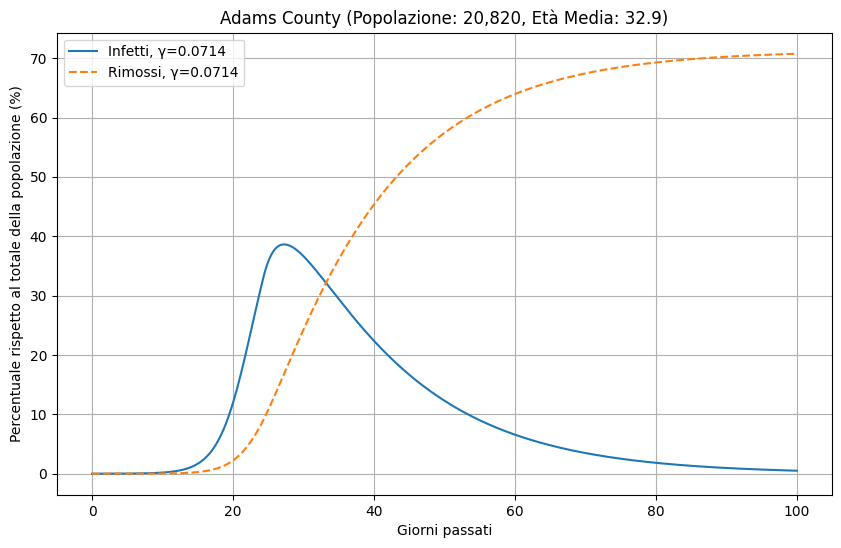

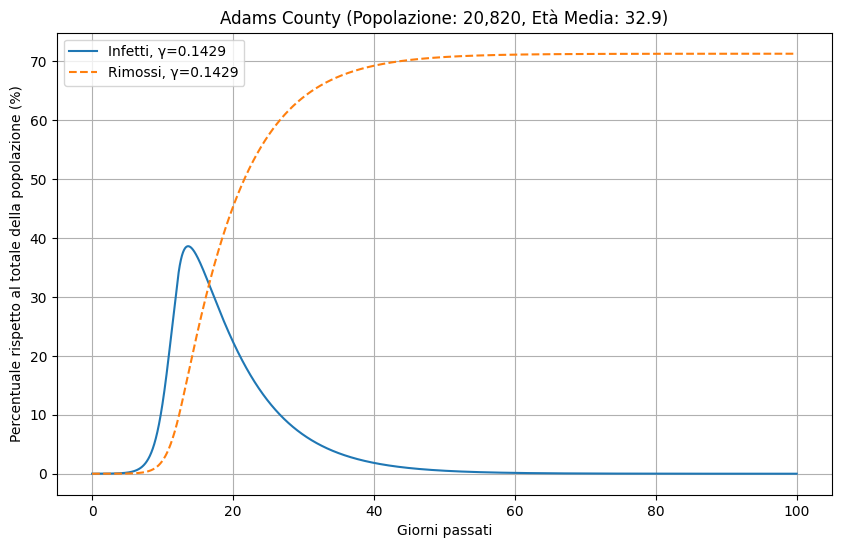

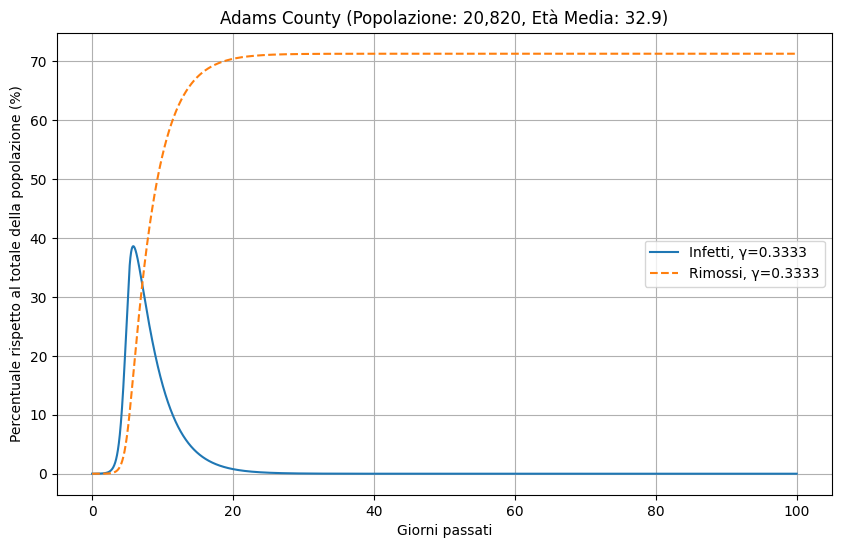

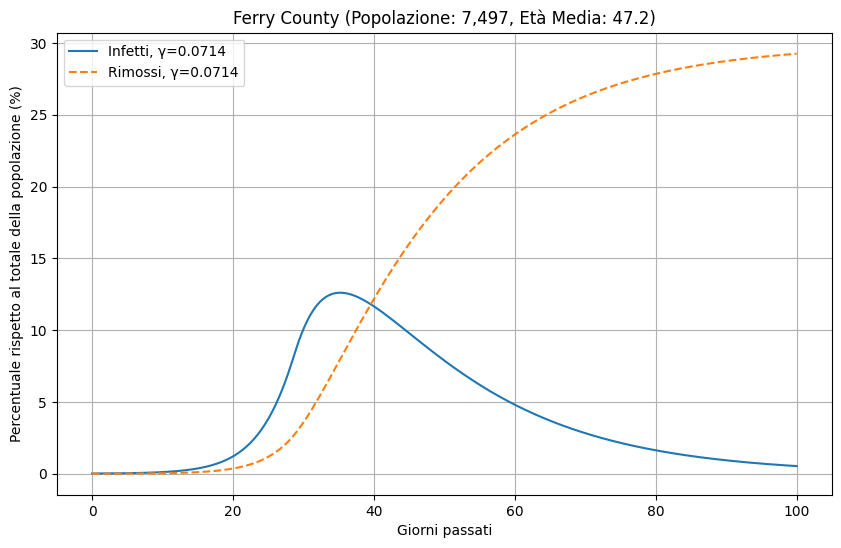

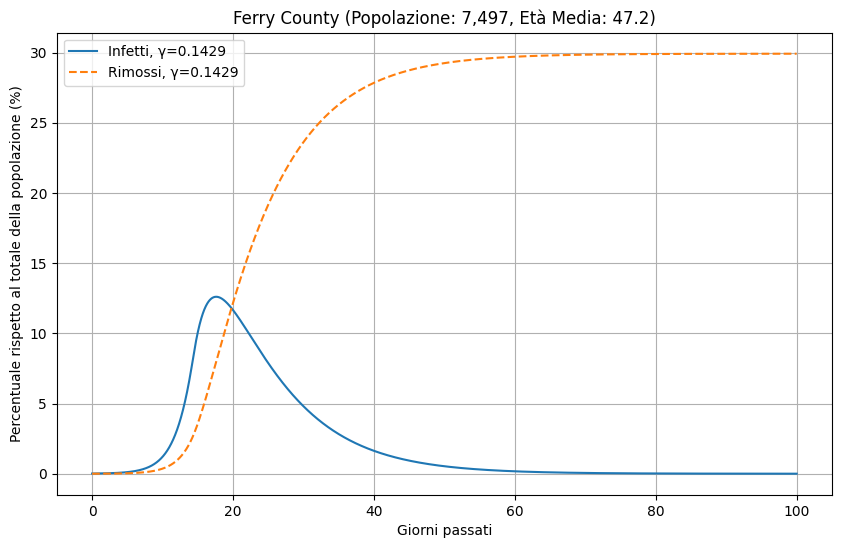

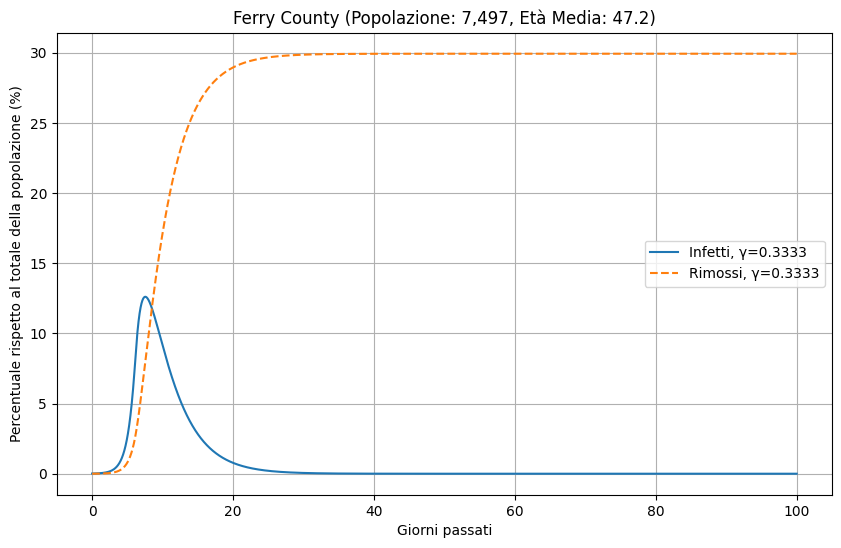

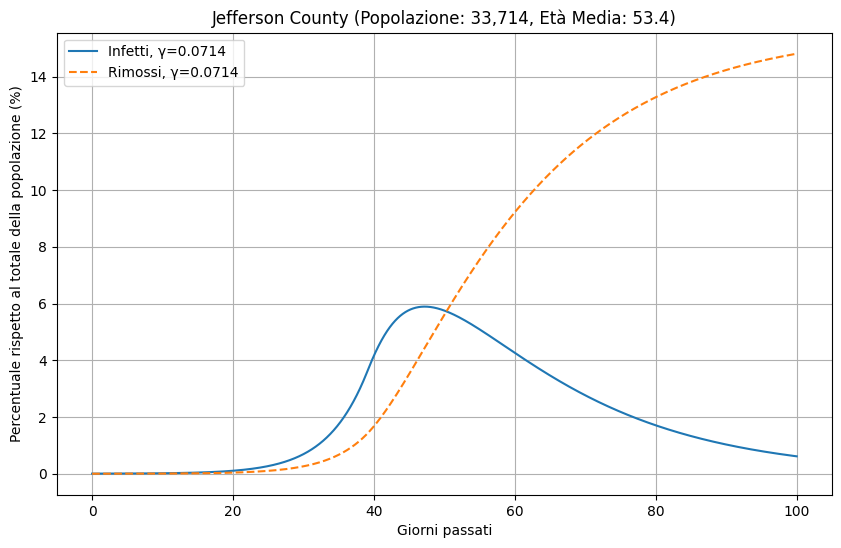

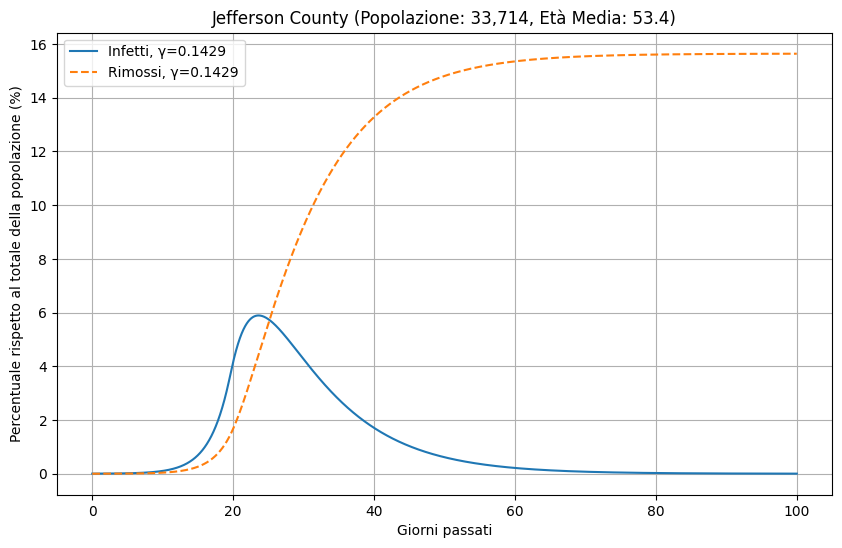

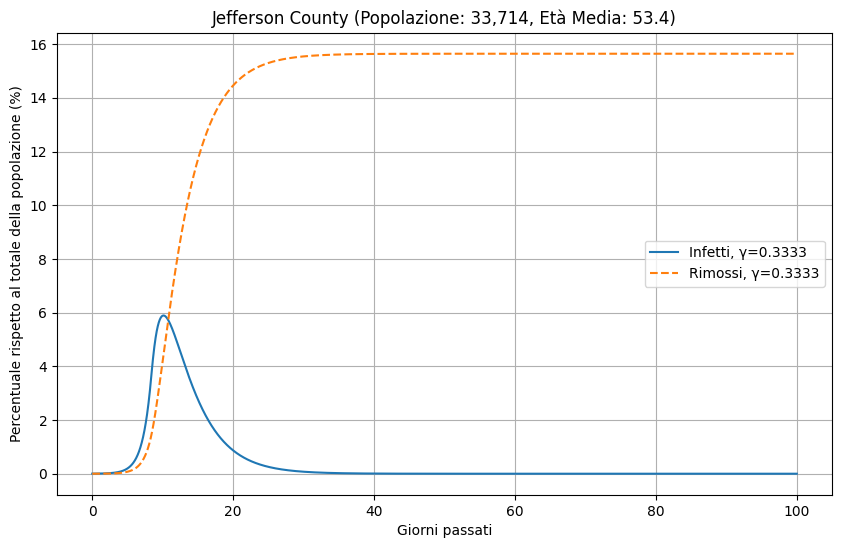

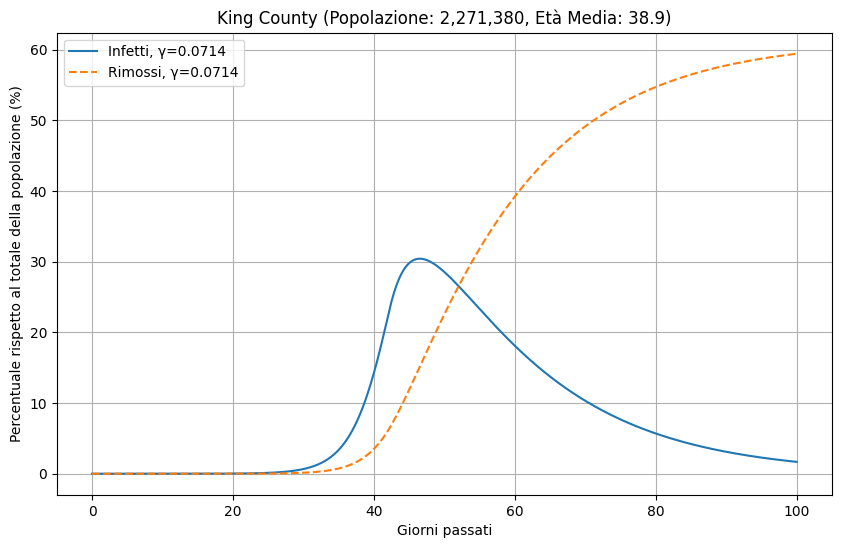

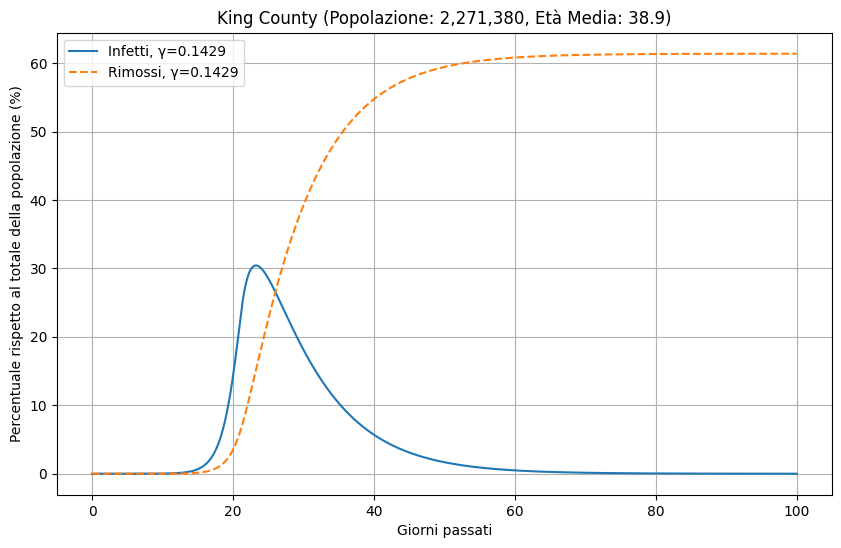

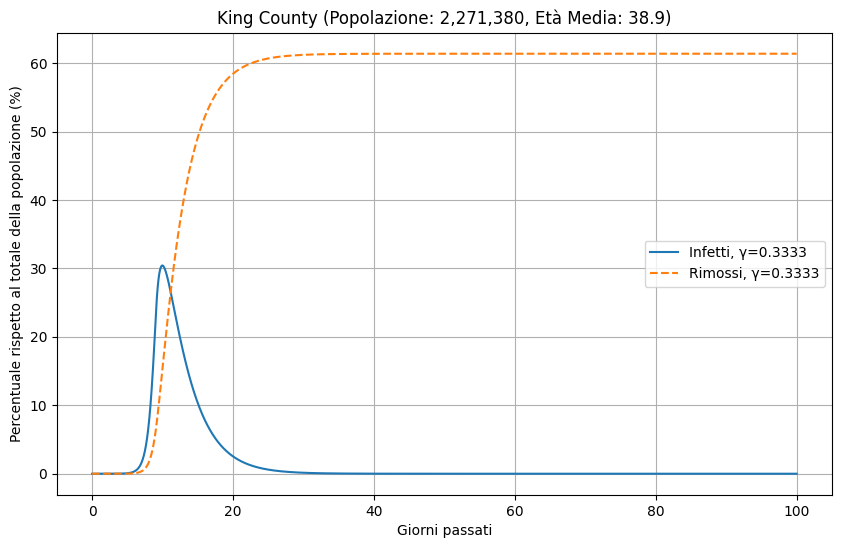

              County   Gamma    Beta  Peak Infected (%)  Day of Peak Infected  \
0       Adams County  0.0714  0.0550          38.626050                 27.25   
1       Adams County  0.1429  0.1100          38.626020                 13.63   
2       Adams County  0.3333  0.2566          38.626049                  5.84   
3       Ferry County  0.0714  0.0550          12.609315                 35.22   
4       Ferry County  0.1429  0.1100          12.609315                 17.61   
5       Ferry County  0.3333  0.2566          12.609299                  7.55   
6   Jefferson County  0.0714  0.0550           5.893459                 47.20   
7   Jefferson County  0.1429  0.1100           5.893459                 23.60   
8   Jefferson County  0.3333  0.2566           5.893454                 10.11   
9        King County  0.0714  0.0550          30.434043                 46.51   
10       King County  0.1429  0.1100          30.434044                 23.25   
11       King County  0.3333

In [167]:
#priority = np.array([1, 1, 1, 2, 2, 3, 4, 20, 20])
priority = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])


M = np.array([
    [19.2, 4.8, 3.0, 7.1, 3.7, 3.1, 2.3, 1.4, 1.4],
    [4.8, 42.4, 6.4, 5.4, 7.5, 5.0, 1.8, 1.7, 1.7],
    [3.0, 6.4, 20.7, 9.2, 7.1, 6.3, 2.0, 0.9, 0.9],
    [7.1, 5.4, 9.2, 16.9, 10.1, 6.8, 3.4, 1.5, 1.5],
    [3.7, 7.5, 7.1, 10.1, 13.1, 7.4, 2.6, 2.1, 2.1],
    [3.1, 5.0, 6.3, 6.8, 7.4, 10.4, 3.5, 1.8, 1.8],
    [2.3, 1.8, 2.0, 3.4, 2.6, 3.5, 7.5, 3.2, 3.2],
    [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2],
    [1.4, 1.7, 0.9, 1.5, 2.1, 1.8, 3.2, 7.2, 7.2]
])
p = county_age_distribution / np.sum(county_age_distribution)

M_normalized = np.dot(M, np.diag(p))
M_normalized = M_normalized.astype(float)
eigenvalues, eigenvectors = np.linalg.eig(M_normalized)
dominant_index = np.argmax(eigenvalues)
lambda_dominant = eigenvalues[dominant_index]
v_dominant = eigenvectors[:, dominant_index]

gamma = 1 / 14  
R0 = 5.7  


gamma_values = np.array([1/14 , 1/7 , 1/3])


def vaccination_rate(S, total_population, priority):
    T = total_population / 720  # Numero di vaccini somministrati al giorno
    weighted_S = priority * S
    sum_weighted_S = np.sum(weighted_S)
    
    if sum_weighted_S > 0:
        mu = T * (weighted_S / sum_weighted_S)  
    else:
        mu = np.zeros_like(S)  
    
    
    mu = np.minimum(mu, S)
    mu = 0
    return mu

# Funzione di mitigazione con limitazione
def mitigation_factor(C, C_max, lambda_param, epsilon):
    C_total = np.sum(C)  # Numero totale di persone in ICU
    mitigation = 1 / (lambda_param * (C_total / C_max + epsilon))
    return min(mitigation, 1)  # Limitare il fattore di mitigazione a un massimo di 1


def deriv(y, t, beta, gamma, M, N, C_max, h, c, m, lambda_param, epsilon, priority):
    S, I, R, H, C, M_death = np.split(y, 6)
    mitigation = mitigation_factor(C, C_max, lambda_param, epsilon)
    M_t = M * mitigation  # Matrice di contatto mitigata
    
    vaccination_vector = vaccination_rate(S, N, priority)
    
    dSdt = -beta * S / N * np.dot(M_t, I) - vaccination_vector
    dIdt = beta * S / N * np.dot(M_t, I) - gamma * I
    dRdt = gamma * I + vaccination_vector
    dHdt = gamma * h * I
    dCdt = gamma * h * c * I
    dMdt = gamma * m * I
    
    return np.concatenate([dSdt, dIdt, dRdt, dHdt, dCdt, dMdt])


gg = 100
step = 100

def simulate_county(county_age_distribution, total_population, lambda_value, priority):
    S0 = (county_age_distribution.astype(float) * total_population).copy()  
    I0 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])  
    R0 = np.zeros(9)
    H0 = np.zeros(9)
    C0 = np.zeros(9)
    M0 = np.zeros(9)
    y0 = np.concatenate([S0, I0, R0, H0, C0, M0])
    
    t = np.linspace(0, gg, gg*step)  
    ret = odeint(deriv, y0, t, args=(beta, gamma, M, total_population, C_max, h, c, m, lambda_value, epsilon, priority))
    S, I, R, H, C, M_death = np.split(ret.T, 6)
    
    
    R = np.minimum(R, total_population)
    
    return S, I, R, H, C, M_death 

# Parametri per la simulazione
#lambda_values = [0.5]


#gamma_values = [1/3, 1/7, 1/14]  # 3 giorni, 7 giorni, 14 giorni
#R0 = 5.7  # Numero riproduttivo di base

# Parametri per la simulazione
lambda_values = [lambda_dominant]

# Inizializza una lista per salvare i risultati
results = []


for i, county in age_distribution.iterrows():
    county_age_distribution = county.drop('CTYNAME').values
    total_population = pop_df.loc[i, 'total_pop']  
    mean_age = pop_df.loc[i, 'mean_age']  
    N = total_population
    C_max = 34.7 / 10000 * total_population  
    
    for gamma in gamma_values:
        beta = R0 * gamma / lambda_dominant  
        
        plt.figure(figsize=(10, 6))
        
        for lambda_value in lambda_values:
            S, I, R, H, C, M_death = simulate_county(county_age_distribution, total_population, lambda_value, priority)
            
            
            infetti_percentuale = (np.sum(I, axis=0) / total_population) * 100
            rimossi_percentuale = (np.sum(R, axis=0) / total_population) * 100
            ospedalizzati_percentuale = (np.sum(H, axis=0) / total_population) * 100
            ICU_percentuale = (np.sum(C, axis=0) / total_population) * 100
            morti_percentuale = (np.sum(M_death, axis=0) / total_population) * 100
            
            
            plt.plot(np.linspace(0, gg, gg*step), infetti_percentuale, label=f'Infetti, γ={round(gamma, 4)}')
            plt.plot(np.linspace(0, gg, gg*step), rimossi_percentuale, '--', label=f'Rimossi, γ={round(gamma, 4)}')
        
        plt.title(f'{county["CTYNAME"]} (Popolazione: {int(total_population):,}, Età Media: {mean_age:.1f})')
        plt.xlabel('Giorni passati')
        plt.ylabel('Percentuale rispetto al totale della popolazione (%)')
        plt.legend()
        plt.grid(True)
        plt.show()
        # Calcola le metriche
        peak_infected = np.max(np.sum(I, axis=0)) / total_population * 100
        day_peak_infected = np.argmax(np.sum(I, axis=0)) / step
        total_removed = np.sum(R[:, -1]) / total_population * 100
        total_hospitalized = np.sum(H[:, -1]) / total_population * 100
        total_icu = np.sum(C[:, -1]) / total_population * 100
        total_deaths = np.sum(M_death[:, -1]) / total_population * 100
        
        #salva risultati
        results.append({
            'County': county['CTYNAME'],
            'Gamma': round(gamma, 4),
            'Beta': round(beta, 4),
            'Peak Infected (%)': peak_infected,
            'Day of Peak Infected': day_peak_infected,
            'Total Removed (%)': total_removed,
            'Total Hospitalized (%)': total_hospitalized,
            'Total ICU (%)': total_icu,
            'Total Deaths (%)': total_deaths
        })


df_results = pd.DataFrame(results)


print(df_results)

df_results.to_csv('simulation_metrics.csv', index=False)


In [161]:
import pandas as pd

priority = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])

# Nuovo valore di gamma per un periodo infettivo più breve
#gamma = 1 / 7  # 7 giorni di infezione
#gamma = 1 / 14
# Calcolo di un nuovo beta per mantenere R0 costante (R0 ≈ 5.7)
R0 = 5.7
#beta = R0 * gamma


def vaccination_rate(S, total_population, priority):
    T = total_population / 720  # Numero di vaccini somministrati al giorno
    weighted_S = priority * S
    sum_weighted_S = np.sum(weighted_S)
    
    if sum_weighted_S > 0:
        mu = T * (weighted_S / sum_weighted_S)  
    else:
        mu = np.zeros_like(S)  
    
    
    mu = np.minimum(mu, S)
    
    return mu

# Funzione di mitigazione con limitazione
def mitigation_factor(C, C_max, lambda_param, epsilon):
    C_total = np.sum(C)  # Numero totale di persone in ICU
    mitigation = 1 / (lambda_param * (C_total / C_max + epsilon))
    return min(mitigation, 1)  # Limitare il fattore di mitigazione a un massimo di 1



def deriv(y, t, beta, gamma, M, N, C_max, h, c, m, lambda_param, epsilon, priority):
    S, I, R, H, C, M_death = np.split(y, 6)
    mitigation = mitigation_factor(C, C_max, lambda_param, epsilon)
    M_t = M * mitigation  # Matrice di contatto mitigata
    
    vaccination_vector = vaccination_rate(S, N, priority)
    
    dSdt = -beta * S / N * np.dot(M_t, I) - vaccination_vector
    dIdt = beta * S / N * np.dot(M_t, I) - gamma * I
    dRdt = gamma * I + vaccination_vector
    dHdt = gamma * h * I
    dCdt = gamma * h * c * I
    dMdt = gamma * m * I
    
    return np.concatenate([dSdt, dIdt, dRdt, dHdt, dCdt, dMdt])


gg = 100
step = 100


def simulate_county(county_age_distribution, total_population, lambda_value, priority):
    S0 = (county_age_distribution.astype(float) * total_population).copy()  
    I0 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])  
    R0 = np.zeros(9)
    H0 = np.zeros(9)
    C0 = np.zeros(9)
    M0 = np.zeros(9)
    y0 = np.concatenate([S0, I0, R0, H0, C0, M0])
    
    t = np.linspace(0, gg, gg*step)  
    ret = odeint(deriv, y0, t, args=(beta, gamma, M, total_population, C_max, h, c, m, lambda_value, epsilon, priority))
    S, I, R, H, C, M_death = np.split(ret.T, 6)
    
    
    R = np.minimum(R, total_population)
    
    return S, I, R, H, C, M_death 




gamma_values = [1/3, 1/7, 1/14]  # 3 giorni, 7 giorni, 14 giorni di infezione
R0 = 5.7  #numero riproduttivo di base

#parametri per la simulazione
lambda_values = ([lambda_dominant])

#inizializza una lista per salvare i risultati
results = []


for i, county in age_distribution.iterrows():
    county_age_distribution = county.drop('CTYNAME').values
    total_population = pop_df.loc[i, 'total_pop']  
    mean_age = pop_df.loc[i, 'mean_age']  
    N = total_population
    C_max = 34.7 / 100000 * total_population  #capacità massima delle ICU in base alla popolazione totale
    
    for gamma in gamma_values:
        beta = R0 * gamma / lambda_dominant  #calcolo di beta per mantenere R0 costante
        
        
        S, I, R, H, C, M_death = simulate_county(county_age_distribution, total_population, lambda_values[0], priority)
        
        
        peak_infected = np.max(np.sum(I, axis=0)) / total_population * 100
        day_peak_infected = np.argmax(np.sum(I, axis=0)) / step
        total_removed = np.sum(R[:, -1]) / total_population * 100
        total_hospitalized = np.sum(H[:, -1]) / total_population * 100
        total_icu = np.sum(C[:, -1]) / total_population * 100
        total_deaths = np.sum(M_death[:, -1]) / total_population * 100
        
        
        results.append({
            'County': county['CTYNAME'],
            'Gamma': round(gamma, 4),
            'Beta': round(beta, 4),
            'Peak Infected (%)': peak_infected,
            'Day of Peak Infected': day_peak_infected,
            'Total Removed (%)': total_removed,
            'Total Hospitalized (%)': total_hospitalized,
            'Total ICU (%)': total_icu,
            'Total Deaths (%)': total_deaths
        })


df_results = pd.DataFrame(results)


print(df_results)


df_results.to_csv('simulation_metrics.csv', index=False)


              County   Gamma    Beta  Peak Infected (%)  Day of Peak Infected  \
0       Adams County  0.3333  0.2566          11.624157                  5.16   
1       Adams County  0.1429  0.1100          11.496060                 12.08   
2       Adams County  0.0714  0.0550          11.270758                 24.26   
3       Ferry County  0.3333  0.2566           1.697401                  5.79   
4       Ferry County  0.1429  0.1100           1.675680                 13.54   
5       Ferry County  0.0714  0.0550           1.637603                 27.16   
6   Jefferson County  0.3333  0.2566           0.673215                  7.67   
7   Jefferson County  0.1429  0.1100           0.660450                 17.95   
8   Jefferson County  0.0714  0.0550           0.638026                 36.12   
9        King County  0.3333  0.2566           5.754413                  9.01   
10       King County  0.1429  0.1100           5.625314                 21.15   
11       King County  0.0714